In [ ]:
%pip install networkx matplotlib pandas pytest-dotenv


In [ ]:
import os
import requests
import time
import json
from tqdm import tqdm
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv('SEMANTIC_SCHOLAR_API_KEY')

In [131]:
# Function to handle rate limiting
def rate_limited_request(url, headers, limit=10, endpoint_type='other'):
    # if endpoint_type in ['paper/batch', 'paper/search', 'recommendations']:
    #     time.sleep(1) 
    # else:
    time.sleep(1.0 / limit)  

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  
        return response
    except requests.RequestException as e:
        print(f"Request error: {e}")
        return None

# Get paperId, get list of paper references (list of paperIds)
def get_references(title, api_key):
    url = f"https://api.semanticscholar.org/graph/v1/paper/search?query={title}&limit=1&fields=references"
    headers = {"x-api-key": api_key}
    response = rate_limited_request(url, headers, endpoint_type='paper/search')

    if response:
        data = response.json()
        if 'data' in data and data['data']:
            paper_id = data['data'][0]['paperId']

            references = data['data'][0].get('references', [])
            reference_ids = [ref['paperId'] for ref in references if 'paperId' in ref]
            return paper_id, reference_ids
        else:
            # print(f"No matching paper found for title: '{title}'")
            return None, []
    else:
        print(f"No response from API for title: '{title}'")
        return None, []
    
# Function to get the title for a given paper ID
def get_paper_title(paper_id, api_key):
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}"
    headers = {"x-api-key": api_key}
    response = rate_limited_request(url, headers)

    if response and response.status_code == 200:
        data = response.json()
        return data.get('title')
    else:
        print(f"Failed to fetch data for paper ID: {paper_id}")
        return None
    
def get_references_by_paper_id(paper_id, api_key):
    url = f"https://api.semanticscholar.org/graph/v1/paper/{paper_id}/references?fields=title,authors&limit=1000"
    headers = {"x-api-key": api_key}
    response = rate_limited_request(url, headers)

    if response and response.status_code == 200:
        data = response.json()
        reference_ids = []

        if 'data' in data:
            for ref in data['data']:
                if 'citedPaper' in ref and 'paperId' in ref['citedPaper']:
                    reference_ids.append(ref['citedPaper']['paperId'])

        return reference_ids
    return []

In [ ]:
#First main function to run this for the entire datatset

# Path to the directory containing the PDF files
paper_directory = './PapersDirectory/papers'  # Change this to your directory path

# Check if the directory exists
if not os.path.exists(paper_directory):
    print(f"Directory does not exist: {paper_directory}")
else:
    # List all PDF files in the directory
    pdf_files = [f for f in os.listdir(paper_directory) if f.endswith('.pdf')]

    # Print the number of PDF files found
    print(f"Number of PDF files found: {len(pdf_files)}")

    # Limiting the number of papers processed
    # max_papers = 10
    # pdf_files = pdf_files[:max_papers]

    # Extracting titles from the file names (assuming filename is title.pdf)
    paper_titles = [os.path.splitext(f)[0] for f in pdf_files]


paper_references = {}
unmatched_titles = {}

# Processing the papers with a progress bar
for title in tqdm(paper_titles, desc="Processing Papers"):
    paper_id, references = get_references(title, api_key)
    if paper_id:
        paper_references[paper_id] = references
    else:
        unmatched_titles[title] = "No matching paper ID found"

# Save the results to JSON files
with open('paper_references.json', 'w') as json_file:
    json.dump(paper_references, json_file, indent=4)
print("Data saved to paper_references.json")

with open('unmatched_titles.json', 'w') as json_file:
    json.dump(unmatched_titles, json_file, indent=4)
print("Data saved to unmatched_titles.json")

In [ ]:
#Second main to add important papers not in our original dataset


paper_references = {}
unmatched_titles = {}

titles = ["Bounding the Capabilities of Large Language Models in Open Text Generation with Prompt Constraints",
"Language Models are Few-Shot Learners",
"A Survey on In-context Learning",
"What Makes Good In-Context Examples for GPT-3?",
"Finding Support Examples for In-Context Learning",
"Unified Demonstration Retriever for In-Context Learning",
"Fantastically Ordered Prompts and Where to Find Them: Overcoming Few-Shot Prompt Order Sensitivity",
"Reordering Examples Helps during Priming-based Few-Shot Learning",
"Learning To Retrieve Prompts for In-Context Learning",
"Self-Generated In-Context Learning: Leveraging Auto-regressive Language Models as a Demonstration Generator",
"Large Language Models are Zero-Shot Reasoners",
"Large Language Models Are Human-Level Prompt Engineers",
"Take a Step Back: Evoking Reasoning via Abstraction in Large Language Models",
"Thread of Thought Unraveling Chaotic Contexts",
"When to Make Exceptions: Exploring Language Models as Accounts of Human Moral Judgment",
"Automatic Chain of Thought Prompting in Large Language Models",
"True Detective: A Deep Abductive Reasoning Benchmark Undoable for GPT-3 and Challenging for GPT-4",
"Contrastive Chain-of-Thought Prompting",
"Gemini: A Family of Highly Capable Multimodal Models",
"Complexity-Based Prompting for Multi-Step Reasoning",
"Active Prompting with Chain-of-Thought for Large Language Models",
"MoT: Memory-of-Thought Enables ChatGPT to Self-Improve",
"Measuring and Narrowing the Compositionality Gap in Language Models",
"Automatic Prompt Augmentation and Selection with Chain-of-Thought from Labeled Data",
"Tab-CoT: Zero-shot Tabular Chain of Thought",
"Is a Question Decomposition Unit All We Need?",
"Least-to-Most Prompting Enables Complex Reasoning in Large Language Models",
"Decomposed Prompting: A Modular Approach for Solving Complex Tasks",
"Plan-and-Solve Prompting: Improving Zero-Shot Chain-of-Thought Reasoning by Large Language Models",
"Tree of Thoughts: Deliberate Problem Solving with Large Language Models",
"Large Language Model Guided Tree-of-Thought",
"Cumulative Reasoning with Large Language Models",
"Graph of thoughts: Solving elaborate problems with large language models",
"Recursion of Thought: A Divide-and-Conquer Approach to Multi-Context Reasoning with Language Models",
"Program of Thoughts Prompting: Disentangling Computation from Reasoning for Numerical Reasoning Tasks",
"Faithful Chain-of-Thought Reasoning",
"Skeleton-of-Thought: Large Language Models Can Do Parallel Decoding",
"Exploring Demonstration Ensembling for In-context Learning",
"$k$NN Prompting: Beyond-Context Learning with Calibration-Free Nearest Neighbor Inference",
"An Information-theoretic Approach to Prompt Engineering Without Ground Truth Labels",
"Self-Consistency Improves Chain of Thought Reasoning in Language Models",
"Universal Self-Consistency for Large Language Model Generation",
"Making Language Models Better Reasoners with Step-Aware Verifier",
"Language Models (Mostly) Know What They Know",
"Self-Refine: Iterative Refinement with Self-Feedback",
"RCOT: Detecting and Rectifying Factual Inconsistency in Reasoning by Reversing Chain-of-Thought",
"Large Language Models are Better Reasoners with Self-Verification",
"Deductive Verification of Chain-of-Thought Reasoning",
"Chain-of-Verification Reduces Hallucination in Large Language Models",
"Maieutic Prompting: Logically Consistent Reasoning with Recursive Explanations",
"Large Language Models Understand and Can be Enhanced by Emotional Stimuli",
"Re-Reading Improves Reasoning in Language Models",
"Think Twice: Perspective-Taking Improves Large Language Models' Theory-of-Mind Capabilities",
"Better Zero-Shot Reasoning with Self-Adaptive Prompting",
"Universal Self-Adaptive Prompting",
"System 2 Attention (is something you might need too)",
"Large Language Models as Optimizers",
"Rephrase and Respond: Let Large Language Models Ask Better Questions for Themselves"]

# Processing the papers with a progress bar
for title in tqdm(titles):
    paper_id, references = get_references(title, api_key)
    if paper_id:
        paper_references[paper_id] = references
    else:
        unmatched_titles[title] = "No matching paper ID found"

# Save the results to JSON files
with open('paper_references_additional.json', 'w') as json_file:
    json.dump(paper_references, json_file, indent=4)
print("Data saved to paper_references_additional.json")

with open('unmatched_titles_additional.json', 'w') as json_file:
    json.dump(unmatched_titles, json_file, indent=4)
print("Data saved to unmatched_titles_additional.json")


In [133]:

# Load the unmatched titles
with open('unmatched_titles.json', 'r') as file:
    unmatched_titles = json.load(file)

# Read the CSV file
df = pd.read_csv('master_papers.csv')


# Process papers
paper_references = {}
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Papers"):
    title = row['title']
    source = row['source']
    paper_id = row['paperId']

    if title in unmatched_titles and source == 'Semantic Scholar':
        references = get_references_by_paper_id(paper_id, api_key)
        paper_references[paper_id] = references



# Save the results to JSON file
with open('paper_references_from_csv.json', 'w') as file:
    json.dump(paper_references, file, indent=4)

print("Data saved to paper_references_from_csv.json")

Processing Papers: 100%|██████████| 1464/1464 [00:00<00:00, 61458.08it/s]

142


In [ ]:
#Merge the two files

# Load the existing data from both JSON files
with open('paper_references.json', 'r') as file:
    paper_references = json.load(file)

with open('paper_references_additional.json', 'r') as file:
    paper_references_additional = json.load(file)

with open('paper_references_from_csv.json', 'r') as file:
    paper_references_from_csv = json.load(file)

# Merge the two dictionaries
# If there are duplicate keys, the values from paper_references_additional will be used
paper_references.update(paper_references_additional)
paper_references.update(paper_references_from_csv)


# Save the merged data back to a JSON file
with open('new_merged_paper_references.json', 'w') as file:
    json.dump(paper_references, file, indent=4)

print("Merged data saved to merged_paper_references.json")


In [ ]:
#Only keep refernces which refer to papers in our combined dataset

# Load the merged paper references
with open('new_merged_paper_references.json', 'r') as file:
    merged_paper_references = json.load(file)

# Filter the references so that only those that are keys in the dictionary are kept
for paper_id, references in merged_paper_references.items():
    merged_paper_references[paper_id] = [ref for ref in references if ref in merged_paper_references]

# Save the cleaned data back to a JSON file
with open('new_cleaned_merged_paper_references.json', 'w') as file:
    json.dump(merged_paper_references, file, indent=4)

print("Cleaned data saved to cleaned_merged_paper_references.json")


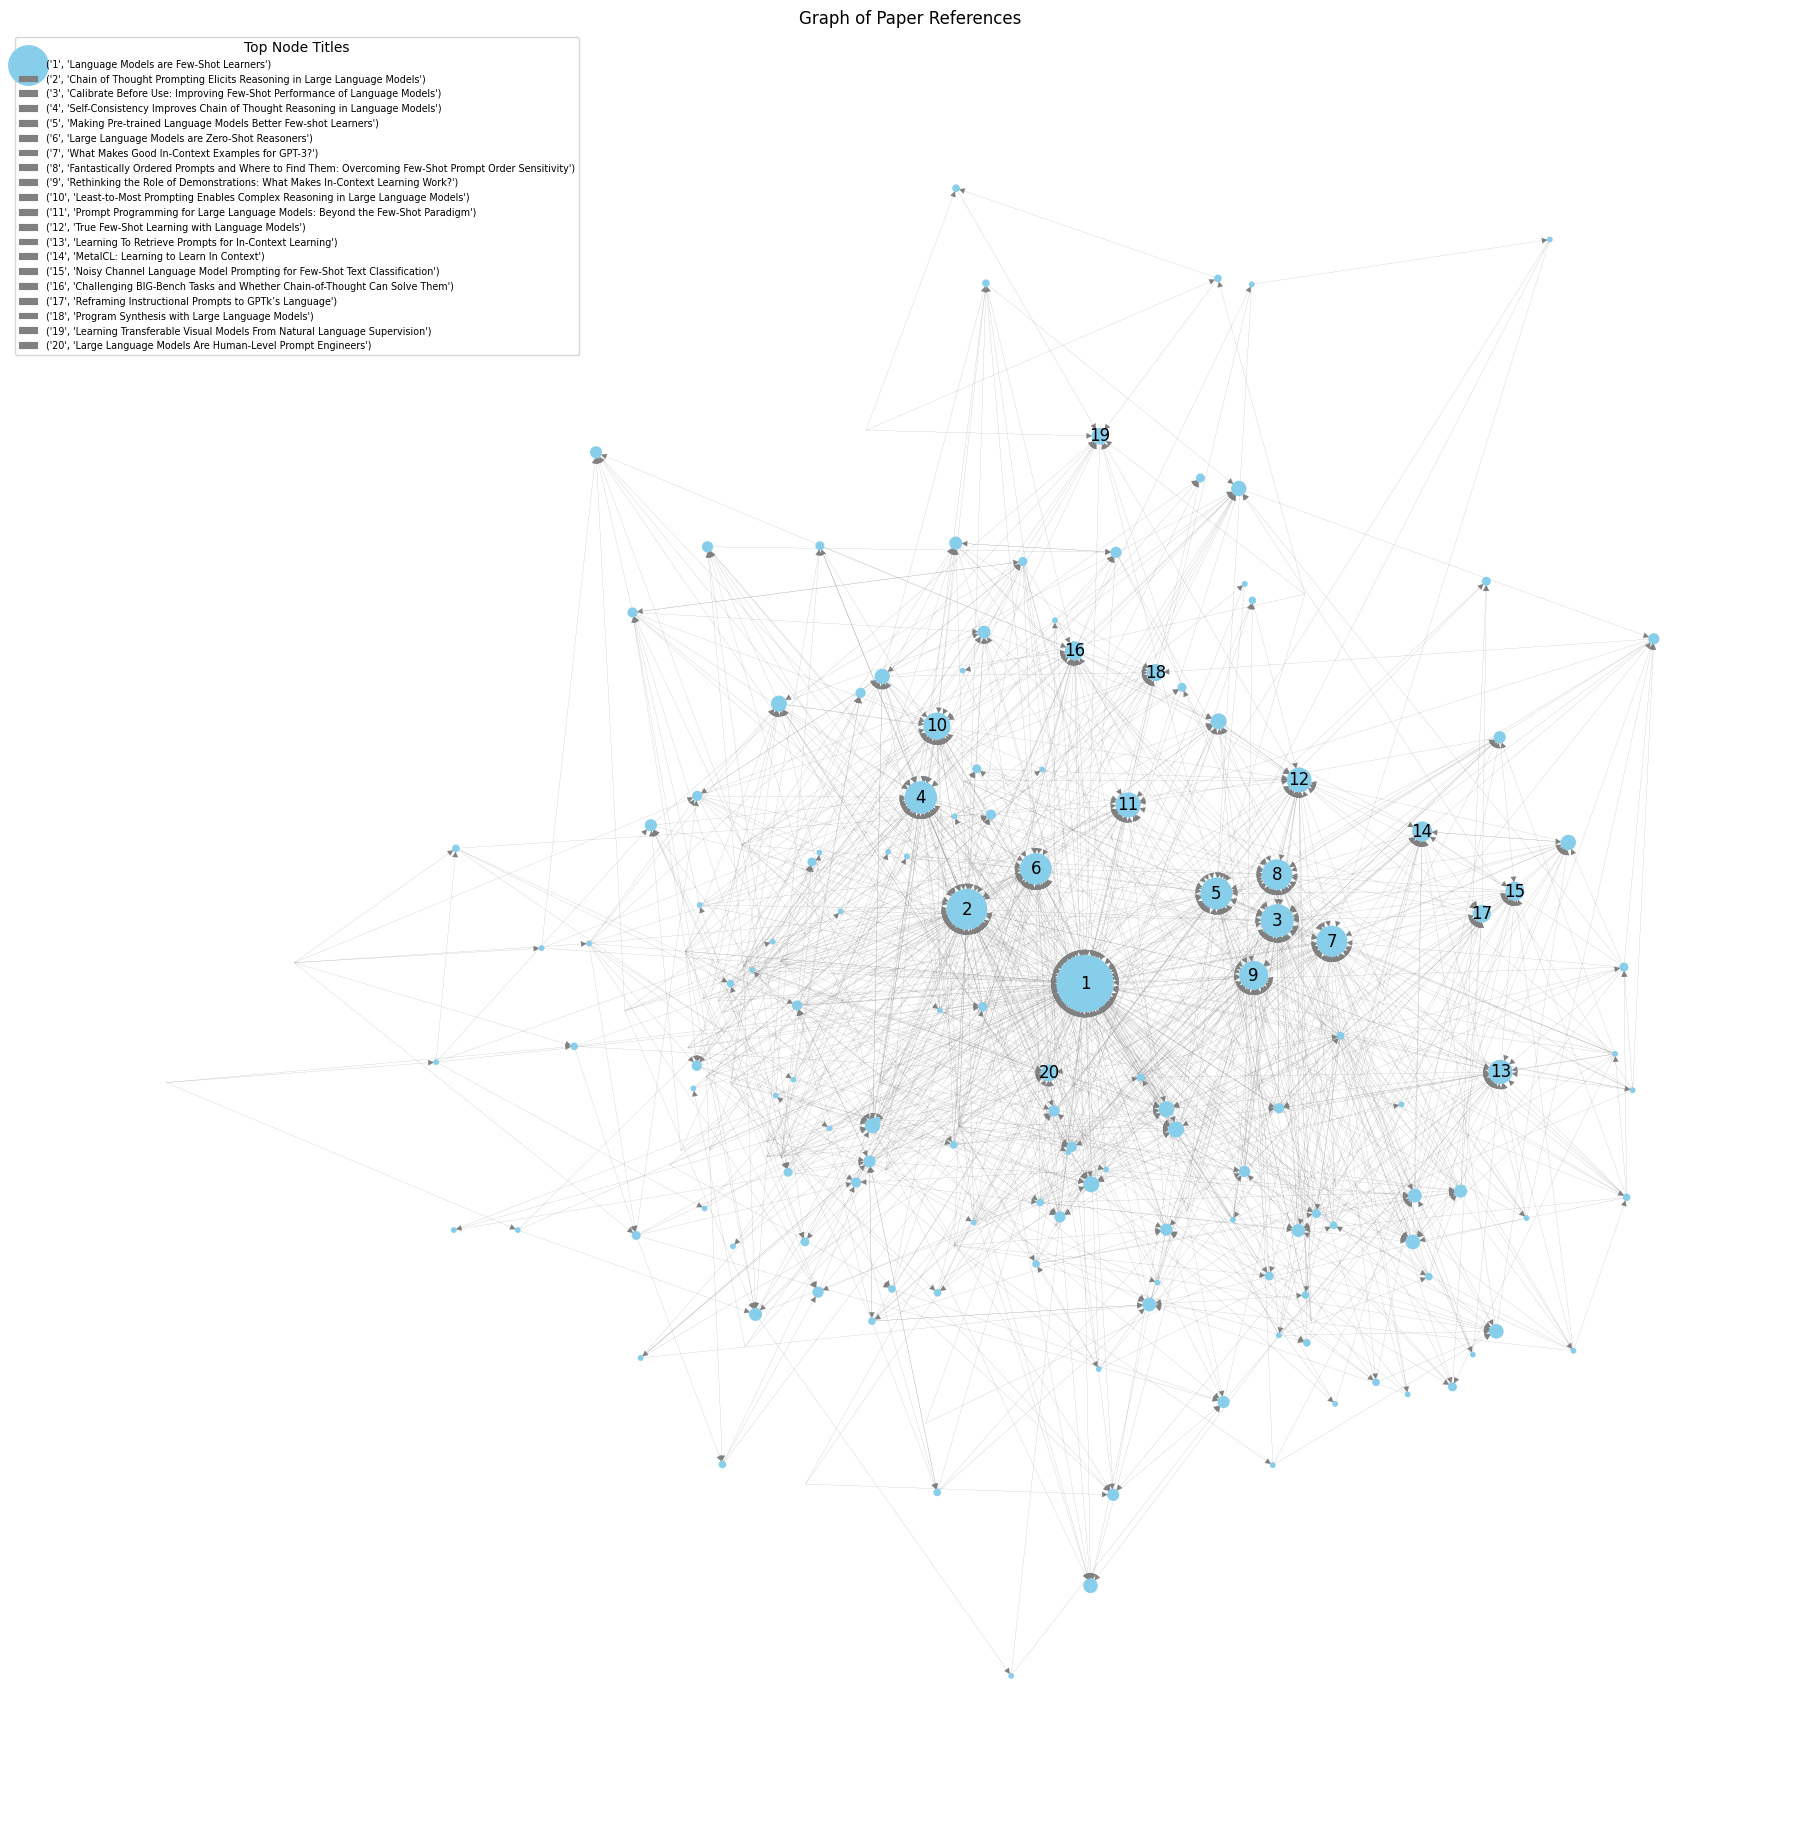

In [129]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the cleaned references
with open('new_cleaned_merged_paper_references.json', 'r') as json_file:
    paper_references = json.load(json_file)

# Create the graph
G = nx.DiGraph()
for paper_id, references in paper_references.items():
    for ref_id in references:
        G.add_edge(paper_id, ref_id)

# Remove isolated nodes if needed
G.remove_nodes_from(list(nx.isolates(G)))

nodes_to_remove = [node for node in G.nodes() if G.in_degree(node) < 4]
G.remove_nodes_from(nodes_to_remove)

# Find the top 20 nodes with the most incoming edges
top_nodes = sorted(G.nodes(), key=lambda n: G.in_degree(n), reverse=True)[:20]

# Convert paper IDs to titles for the top nodes
titles_above_threshold = {}
for paper_id in top_nodes:
    title = get_paper_title(paper_id, api_key)
    if title:
        titles_above_threshold[paper_id] = title


# Cap the maximum node size to prevent too large nodes
max_size = 100000  # Maximum size for a node
node_sizes = [min(G.in_degree(node) * 10, max_size) for node in G.nodes()]

# Draw the graph with adjusted layout parameters
plt.figure(figsize=(18, 18))  # Increased figure size for more space
pos = nx.kamada_kawai_layout(G, dist=None, scale=1.5)  # Adjust 'scale' as needed
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color='skyblue', edge_color='gray', width=0.1)

# Assign and label top nodes with numbers
node_labels = {node: str(index + 1) for index, node in enumerate(top_nodes)}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

# Create a smaller legend (number to title mapping)
legend_labels = {str(index + 1): label for index, (node, label) in enumerate(titles_above_threshold.items())}
plt.legend(legend_labels.items(), title="Top Node Titles", loc='upper left', fontsize='x-small')

plt.title("Graph of Paper References")
plt.show()
